In [19]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore, linregress, pearsonr
from matplotlib.colors import LogNorm
import os
import pycwt as cwt
import pickle
# from sklearn.linear_model import RANSACRegressor
import datetime as datetime

In [20]:
FS = 4 # E4 sampling rate
FREQ_ARRAY = np.append(np.arange(23, 26, 1), np.arange(6*24, 9*24, 24)) # for morlet
PANDAS_RESAMPLE_RATE = "{:.4f}".format(1/FS)+'S' # find missing samples (datetime)

MODALITY = 'eda'

# wavelet and filter variables                    
mother = cwt.Morlet(6)

In [26]:
HDRS_17_CUTOFF = 20
HDRS_24_CUTOFF = 10
RCI_HDRS_17 = 6

HDRS_variant = 'hamd_17_score'

LABEL_FOLDER_PATH = 'labels/'
SAVE_CWT_FOLDER = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/cwt_' + MODALITY + '_all_freq/'

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

In [4]:
def plot_signal(df,
                fs,
                label,
                ylim = None):
    
    plt.figure(figsize=(15, 5))
    
    t = df.index.to_series()
    x = df[label]
    xtick_freq = int(fs*60*60*24*7)
    
    plt.plot(range(len(t)), x, label = label)
    plt.legend(loc=1)
    plt.xticks(range(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')

    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Date')
    plt.ylabel('EDA [uS]')
    plt.grid()

In [5]:
def remove_artifacts_and_interpolate(df, 
                                    fs, 
                                    pandas_resample_rate,
                                    interpolate_method = 'time',
                                    z_score = True):
    
    # if z_score:
    #     print('modified z score')
    #     med_eda = df[MODALITY].median()
    #     med_dev_eda = (np.abs(df[MODALITY] - med_eda)).median()
    #     df[MODALITY] = df[MODALITY].apply(lambda x : 0.6745*(x - med_eda) / med_dev_eda)
    
    df_without_artifacts = df.resample(pandas_resample_rate).mean()
    
    # From the appendix of Stirling et al., 2021 - do not use, seems 'cheating'
    # df_without_artifacts['hour'] = df_without_artifacts.index.to_series().apply(lambda x : x.hour)    
    # df_without_artifacts[MODALITY] = df_without_artifacts.groupby('hour', group_keys=False)[MODALITY].apply(lambda x: x.fillna(x.mean()))
    
    df_without_artifacts.fillna(df_without_artifacts[MODALITY].median(), inplace=True)
    
    if z_score:
        print('z-scored')
        df_without_artifacts[MODALITY] = zscore(df_without_artifacts[MODALITY])

    return df_without_artifacts

In [6]:
def apply_fir(eda: np.ndarray,
              fs,
              cutoff,
              filter_type, # bandpass, lowpass, highpass, bandstop
              transition_band,
              window) -> np.ndarray:
    
    if window == 'hann' or window == 'hamming' or window == 'bartlett':
        M = int(4 * fs / transition_band)
    elif window == 'blackman':
        M = int(6 * fs / transition_band)
    else:
        raise ValueError('Length estimation for this window not implemented')
        
    # print('Using ' + window + ' window for ' + filter_type + ' FIR filter.')
    h = signal.firwin(numtaps = M, 
                      cutoff = cutoff,
                      fs = fs,
                      pass_zero = filter_type,
                      window = window)
    
    eda = np.squeeze(eda)
    return signal.lfilter(h, [1.0], eda) 
    # return signal.filtfilt(h, [1.0], eda) # avoid phase shift of single filter

In [7]:
def morlet_wavelet(eda: np.ndarray, 
                   fs, 
                   freq_arr, 
                   w = 6):
    
    widths = w * fs / (2 * freq_arr * np.pi)
    cwtm = signal.cwt(eda, signal.morlet2, widths, w = w)
    
    return np.abs(cwtm)


In [8]:
all_peaks_dict = {}
all_power_dict = {}

sig_peaks_dict = {}
sig_power_dict = {}

for file in os.listdir(DATA_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("worn_left.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = DATA_FOLDER_PATH+filename
        
        print(eda_filepath, subject)
        
        df = pd.read_hdf(eda_filepath)

        # plot_signal(df = df, label = MODALITY, fs = FS)
        df_without_artifacts = remove_artifacts_and_interpolate(df = df, 
                                                                    fs = FS, 
                                                                    pandas_resample_rate = PANDAS_RESAMPLE_RATE, 
                                                                    z_score = True)
        
        # delta = df_without_artifacts.index[-1] - df_without_artifacts.index[0]
        # n = delta.total_seconds()/3600/2
        # freqs = np.append(np.arange(20, 28, 1), np.arange(28, 3*24, 4))
        # freqs = np.append(freqs, np.arange(3*24, 9*24, 6))
        # freqs = np.append(freqs, np.arange(9*24, int(n), 12))
        freqs = FREQ_ARRAY
        freqs = (1/freqs)
        
        # wavelet
        resampled_df = df_without_artifacts.resample('T').median()
        y = resampled_df[MODALITY].to_numpy()
        dt = 1/60
        alpha, _, _ = cwt.ar1(y) # lag 1 autocorrelation for significance
        wave, scales, freqs, coi, fft, fftfreqs = cwt.cwt(signal = y, dt = dt, wavelet = mother, freqs = freqs)
        power = np.abs(wave) ** 2 # [len(freq), t]
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        
        # save downsampled cwt of each subject
        subject_cwt_df = pd.DataFrame(power.T, columns = [str(p) for p in period])
        cwt_h5_name = SAVE_CWT_FOLDER + subject + '_cwt.h5'
        subject_cwt_df.index = resampled_df.index
        
        # subject_cwt_df = subject_cwt_df.resample('D').median()

        subject_cwt_df.to_hdf(cwt_h5_name, key='df', mode='w')
        
        glbl_power = power.mean(axis=1) # len(freqs)
        dof = y.size - scales  # Correction for padding at edges
        var = y.std()**2
        glbl_signif, tmp = cwt.significance(var, dt, scales, 1, alpha, significance_level=0.95, dof=dof, wavelet=mother)
        # signif, fft_theor = cwt.significance(1.0, dt, scales, 0, alpha, significance_level=0.99, wavelet=mother)
        
        # Find peaks that are significant
        xpeaks = []; powers = []
        ind_peaks = signal.find_peaks(var * glbl_power)[0]
        for i in ind_peaks:
            peak = [var * glbl_power > glbl_signif][0][i]
            if peak:
                if period[i] not in xpeaks:
                    xpeaks.append(period[i])
                    powers.append([var * glbl_power][0][i])
        
        assert len(xpeaks) == len(powers)
        print(xpeaks)
        sig_peaks_dict[subject] = xpeaks
        sig_power_dict[subject] = powers
        

/media/bayesian-posterior/sdc/sensecode_data/temp/SP22_temp_worn_left.h5 SP22
z-scored
[24.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP11_temp_(right but used as)_worn_left.h5 SP11
z-scored
[168.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP27_temp_worn_left.h5 SP27
z-scored
[24.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP44_temp_worn_left.h5 SP44
z-scored
[24.0, 168.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP72_temp_worn_left.h5 SP72
z-scored
[24.0, 168.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP24_temp_worn_left.h5 SP24
z-scored
[24.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP1_temp_worn_left.h5 SP1
z-scored
[24.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP5_temp_worn_left.h5 SP5
z-scored
[]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP6_temp_worn_left.h5 SP6
z-scored
[24.0]
/media/bayesian-posterior/sdc/sensecode_data/temp/SP41_temp_worn_left.h5 SP41
z-scored
[24.0]
/media/bayesian-posterior/sdc/sense

In [18]:
# peak_pkl_file_name = 'sig_peaks_' + MODALITY + '_dict.pkl'
# power_pkl_file_name = 'sig_power_' + MODALITY + '_dict.pkl'

# file1 = open(peak_pkl_file_name, 'wb')
# pickle.dump(sig_peaks_dict, file1)

# file2 = open(power_pkl_file_name, 'wb')
# pickle.dump(sig_power_dict, file2)

In [22]:
def scatter_plot_power_vs_hdrs(all_power_slope_vec, 
                               all_hdrs_slope_vec, 
                               subject_significance_list, 
                               corr_result):
    
    colors = {'significant':'green', 'not significant':'red'}
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(all_power_slope_vec, 
               all_hdrs_slope_vec,
               c = [colors[sig] for sig in subject_significance_list])
    
    ax.plot(all_power_slope_vec, 
            corr_result.intercept + corr_result.slope*np.asarray(all_power_slope_vec), 
            c = 'blue', 
            alpha = 0.5,
            label = 'Correlation = ' + str(round(corr_result.rvalue, 2)))
    
    ax.text(x = 0, 
            y = 0, 
            s = 'p = ' + str(round(corr_result.pvalue, 2)), 
            weight = 'bold', 
            size = 10)
    
    ax.legend(loc = 1)
    ax.grid(True)
    xlabel = 'Slope of Circadian ' + MODALITY.upper() + ' Rhythm Power Over 12 Weeks'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Slope of HDRS Over 12 Weeks')

In [30]:
def linregress_power_and_hrds(df_cwt,
                                freq, 
                                subject,
                                HDRS_array, 
                                HDRS_date):
    
    HDRS_array = zscore(HDRS_array)
    power_array = df_cwt.resample('D').mean()[freq]
    
    # hdrs_RANSAC = RANSACRegressor(random_state=0).fit(HDRS_date.reshape(-1, 1), HDRS_array)
    # hdrs_slope = hdrs_RANSAC.estimator_.coef_[0]
    # hdrs_intercept = np.nan
    
    # power_RANSAC = RANSACRegressor(random_state=0).fit(np.arange(len(power_array)).reshape(-1, 1), power_array)
    # power_slope = power_RANSAC.estimator_.coef_[0]
    # power_intercept = np.nan
        
    hdrs_slope, hdrs_intercept, _, _, _ = linregress(HDRS_array, HDRS_date)    
    power_slope, power_intercept, _, _, _ = linregress(power_array, np.arange(len(power_array)))
                
    return hdrs_slope, hdrs_intercept, -power_slope, power_intercept

In [31]:
# file1 = open(peak_pkl_file_name, 'rb')
# sig_peaks_dict = pickle.load(file1)

# file2 = open('sig_power_eda_dict.pkl', 'rb')
# sig_power_dict = pickle.load(file2)

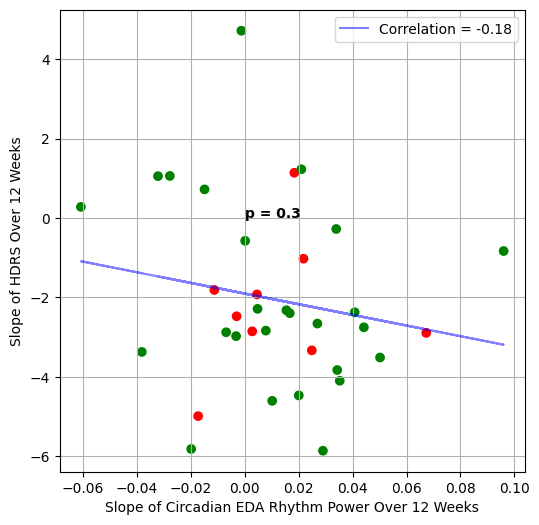

In [32]:
all_hdrs_slope_vec, all_power_slope_vec, subject_significance_list = [], [], []
test_freq = 1.0*24

for file in os.listdir(SAVE_CWT_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("cwt.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = SAVE_CWT_FOLDER+filename
        df_cwt = pd.read_hdf(eda_filepath, 'df')
        
        HDRS_file_name = LABEL_FOLDER_PATH + subject + '_HDRS.csv'
        HDRS_df = pd.read_csv(HDRS_file_name)
        HDRS_df.dropna(inplace = True) # in case of missed HDRS assessment
        HDRS_df = HDRS_df.reset_index()
        HDRS_date = pd.to_datetime(HDRS_df['Date']).map(datetime.datetime.toordinal)
        HDRS_date -= HDRS_date[0]
        HDRS_array = HDRS_df[HDRS_variant].to_numpy()        

        hdrs_slope, hdrs_intercept, power_slope, power_intercept = linregress_power_and_hrds(df_cwt, 
                                                                                            freq = str(test_freq),
                                                                                            subject = subject,
                                                                                            HDRS_array = HDRS_array, 
                                                                                             HDRS_date = HDRS_date.to_numpy())
        
        all_hdrs_slope_vec.append(hdrs_slope)
        all_power_slope_vec.append(power_slope)
        
        if test_freq in sig_peaks_dict[subject]:
            subject_significance_list.append('significant')
        else:
            subject_significance_list.append('not significant')


result = linregress(all_power_slope_vec, all_hdrs_slope_vec)

scatter_plot_power_vs_hdrs(all_power_slope_vec, 
                           all_hdrs_slope_vec, 
                           subject_significance_list, 
                           result)

In [14]:
def plot_peak_power_dist(sig_peaks_dict, sig_power_dict):
    
    sig_peaks_list = []
    avg_power_dict = {}
    
    for subject, peaks in sig_peaks_dict.items():
        
        sig_peaks_list += peaks

        for idx, p in enumerate(peaks):
            rounded_peak = round(p, 0)
            if rounded_peak in avg_power_dict.keys():
                avg_power_dict[rounded_peak].append(p)
            else:
                avg_power_dict[rounded_peak] = [p]
    
    rounded_peak_vec = list(avg_power_dict.keys())
    avg_power_vec = []
    sd_power_vec = []
    for rounded_peak in rounded_peak_vec:
        avg_power_vec.append(np.mean(avg_power_dict[rounded_peak]))
        sd_power_vec.append(np.std(avg_power_dict[rounded_peak]))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    ax1.hist(sig_peaks_list, bins = 'auto', color = 'red', alpha = 0.5)
    ax1.set_xlabel('Period [Hour]')
    ax1.set_ylabel('Number of Subjects')
    ax1.grid(True)
    
    vline_labels = ['1 Day', '7 Days', '30 Days']
    vline_positions = [24, 24*7, 24*30]
    for label, position in zip(vline_labels, vline_positions):
        ax1.axvline(position, color = 'green', label = label)
    ax1.legend(loc=1)
    ax1.set_title('Number of subjects with significant peaks at different periods')
    
#     ax2.errorbar(rounded_peak_vec, 
#                  avg_power_vec, 
#                  fmt = 'o',
#                  yerr = sd_power_vec, 
#                  capsize = 5,
#                  lw = 1,
#                  label ='1 SD')
    
#     ax2.set_xlabel('Period [Hour]')
#     ax2.set_ylabel('Average Power')

#     for label, position in zip(vline_labels, vline_positions):
#         ax2.axvline(position, color = 'green', label = label)
#     ax2.legend(loc=1)
#     ax2.set_title('Average power of significant peaks at different periods over all subjects')
#     ax2.grid(True)


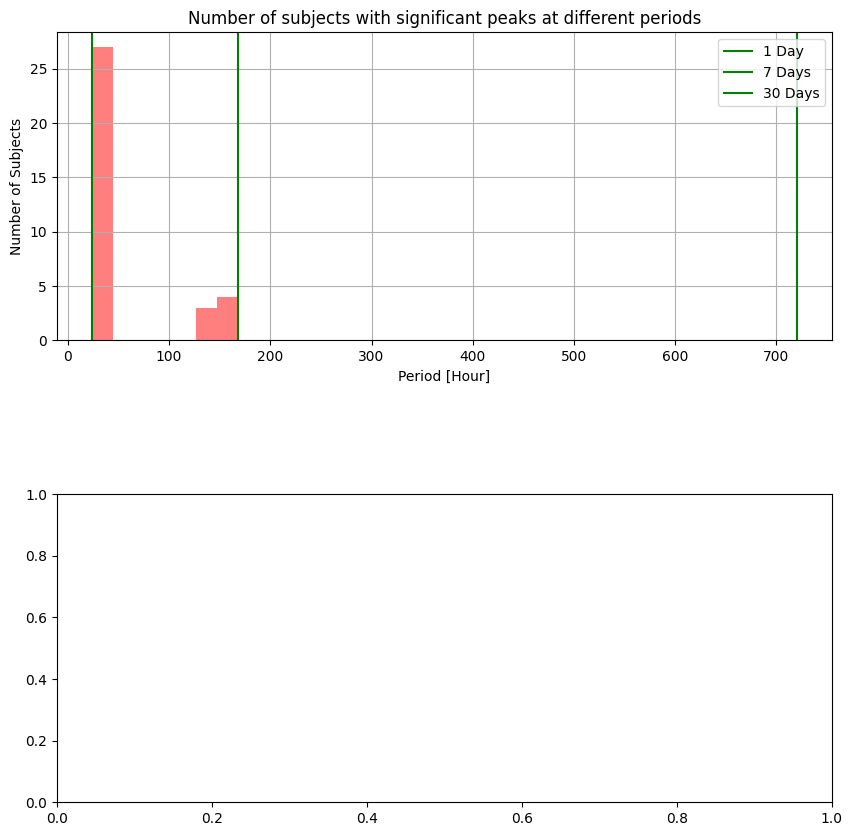

In [15]:
plot_peak_power_dist(sig_peaks_dict, sig_power_dict)